<h1>
Исследовательская работа - построение модели предсказания банкротства стартапов
</h1>

<h2>Цели работы</h2>
<ul>
    <li>
        Анализ основных параметров данных
    </li>
    <li>
        Построение пайплайна модели и нахождение оптимальной модели и её гиперпараметров
    </li>
    <li>
        Сохранение результатов
    </li>
</ul>

## Загрузка данных


In [17]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

import os
import datetime
from phik import phik_matrix

import seaborn as sns

In [18]:
kaggle_startups_train_path_local = '../../data/kaggle_startups_train_28062024.csv'
kaggle_startups_train_path_yandex = '/datasets/kaggle_startups_train_28062024.csv'

kaggle_startups_test_path_local = '../../data/kaggle_startups_test_28062024.csv'
kaggle_startups_test_path_yandex = '/datasets/kaggle_startups_test_28062024.csv'


In [19]:
if os.path.exists(kaggle_startups_train_path_local):
	kaggle_startups_train = pd.read_csv(kaggle_startups_train_path_local)
else:
	kaggle_startups_train = pd.read_csv(kaggle_startups_test_path_yandex)
display(kaggle_startups_train.head(10))

if os.path.exists(kaggle_startups_test_path_local):
	kaggle_startups_test = pd.read_csv(kaggle_startups_test_path_local)
else:
	kaggle_startups_test = pd.read_csv(kaggle_startups_test_path_yandex)
display(kaggle_startups_test.head(10))

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


## Первичный анализ и обработка данных

In [20]:
display(kaggle_startups_train.isna().sum())
kaggle_startups_train['name'] = kaggle_startups_train['name'].fillna('nameless')
kaggle_startups_train['category_list'] = kaggle_startups_train['category_list'].fillna('other')
kaggle_startups_train['funding_total_usd'] = kaggle_startups_train['funding_total_usd'].fillna(0)
kaggle_startups_train['country_code'] = kaggle_startups_train['country_code'].fillna('no_country')
kaggle_startups_train['state_code'] = kaggle_startups_train['state_code'].fillna('no_state')
kaggle_startups_train['region'] = kaggle_startups_train['region'].fillna('no_region')
kaggle_startups_train['city'] = kaggle_startups_train['city'].fillna('no_city')
kaggle_startups_train['closed_at'] = kaggle_startups_train['closed_at'].fillna('2018-01-01')

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [21]:
display(kaggle_startups_test.isna().sum())
kaggle_startups_test['category_list'] = kaggle_startups_test['category_list'].fillna('other')
kaggle_startups_test['funding_total_usd'] = kaggle_startups_test['funding_total_usd'].fillna(0)
kaggle_startups_test['country_code'] = kaggle_startups_test['country_code'].fillna('no_country')
kaggle_startups_test['state_code'] = kaggle_startups_test['state_code'].fillna('no_state')
kaggle_startups_test['region'] = kaggle_startups_test['region'].fillna('no_region')
kaggle_startups_test['city'] = kaggle_startups_test['city'].fillna('no_city')

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [22]:
train_date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
test_date_columns = ['first_funding_at', 'last_funding_at']

def convert_date_to_days_from_origin(time):
	origin = datetime.datetime(1980,1,1)
	return (datetime.datetime.strptime(time, '%Y-%m-%d') - origin).days

for column in train_date_columns:
	kaggle_startups_train[column] = kaggle_startups_train[column].apply(convert_date_to_days_from_origin)

for column in test_date_columns:
	kaggle_startups_test[column] = kaggle_startups_test[column].apply(convert_date_to_days_from_origin)
kaggle_startups_train['lifetime'] = kaggle_startups_train['closed_at'] - kaggle_startups_train['founded_at']
kaggle_startups_train = kaggle_startups_train.drop(columns=['founded_at', 'closed_at', 'name'])

In [23]:
kaggle_startups_train['categories_amount'] = kaggle_startups_train['category_list'].apply(lambda x: len(x.split('|')))

In [24]:
def plotGraphsForNumericColumn(columnName, bins = 30, dataFrame = kaggle_startups_train):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    sns.histplot(ax=axes[0], x=dataFrame[columnName], bins = bins)
    axes[0].set_title(columnName)
    axes[0].set(ylabel = 'Количество экземпляров')

    sns.boxplot(ax=axes[1], x=dataFrame[columnName])
    axes[1].set_title(columnName)

In [25]:
numeric_columns = ['funding_total_usd', 'lifetime', 'first_funding_at', 'lifetime', 'last_funding_at', 'categories_amount']

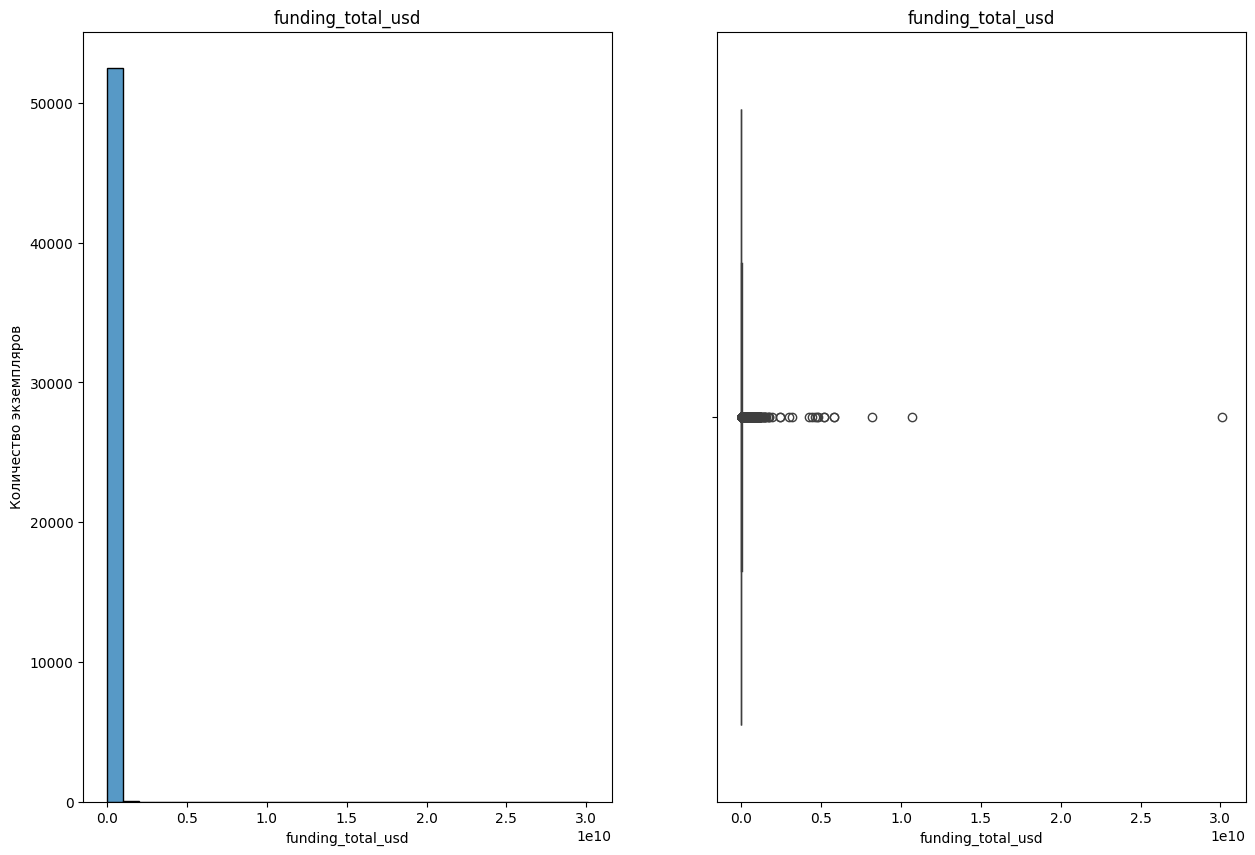

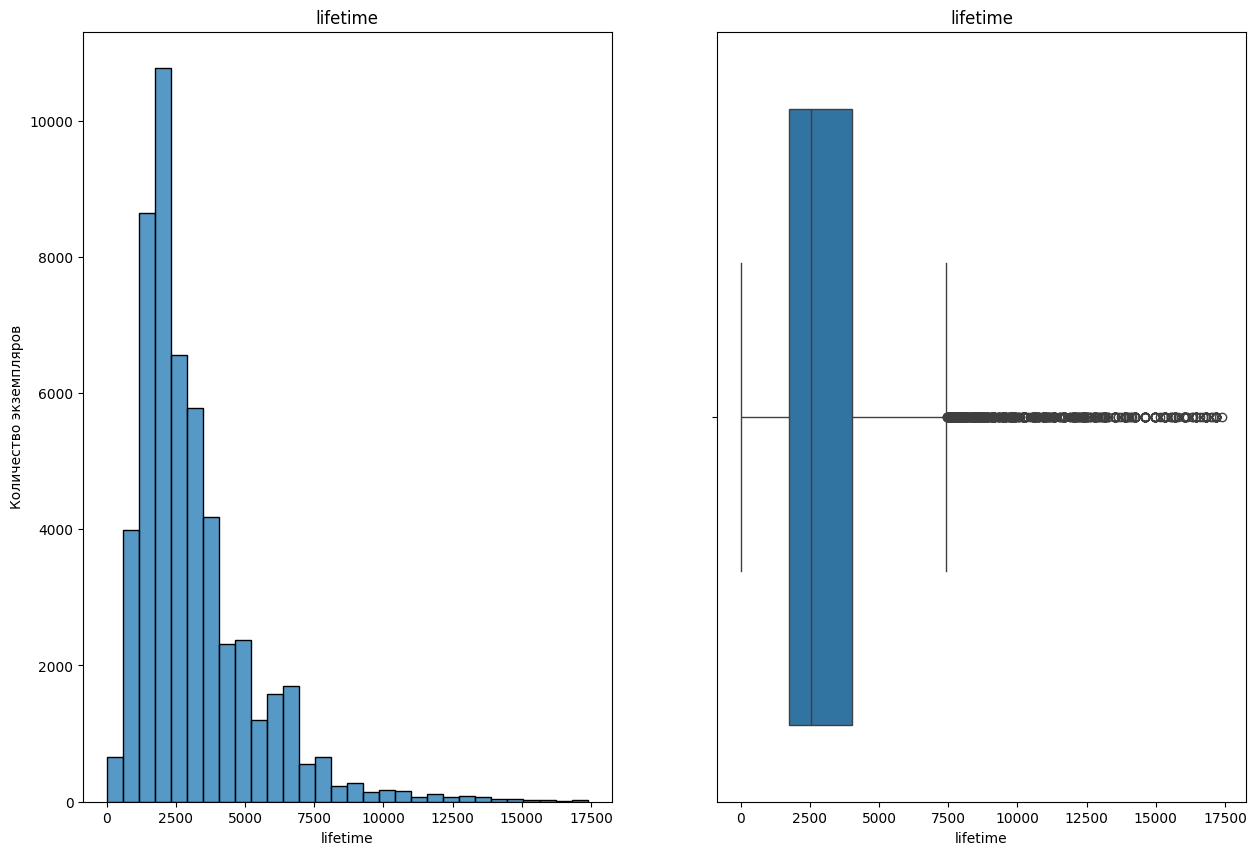

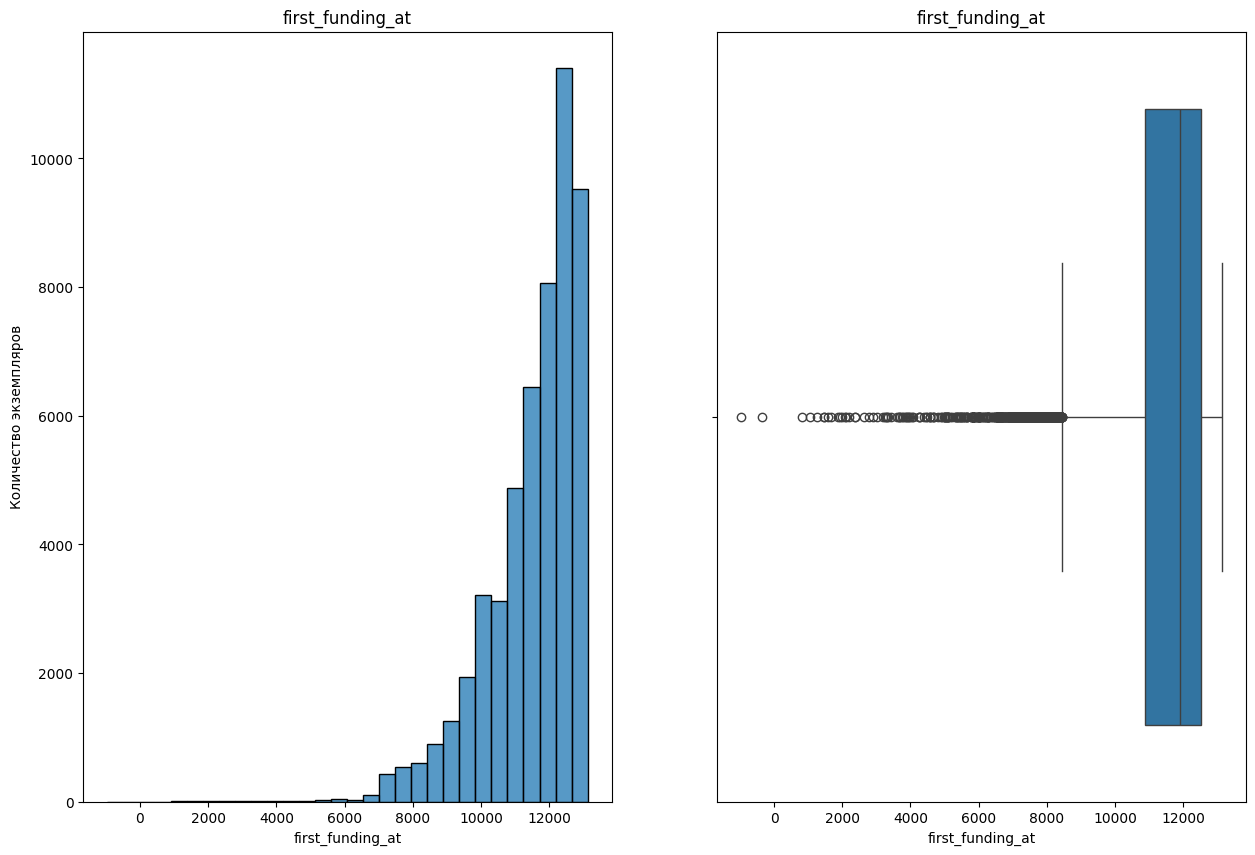

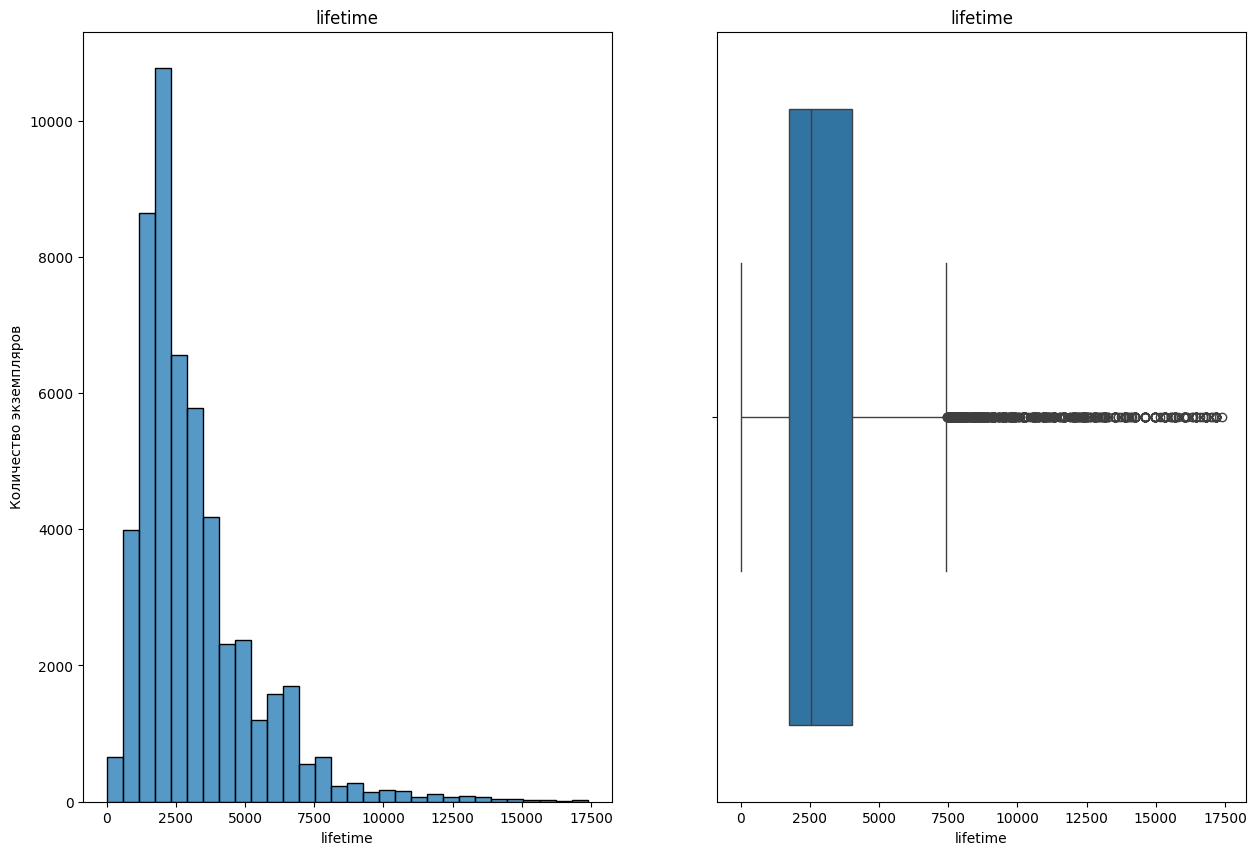

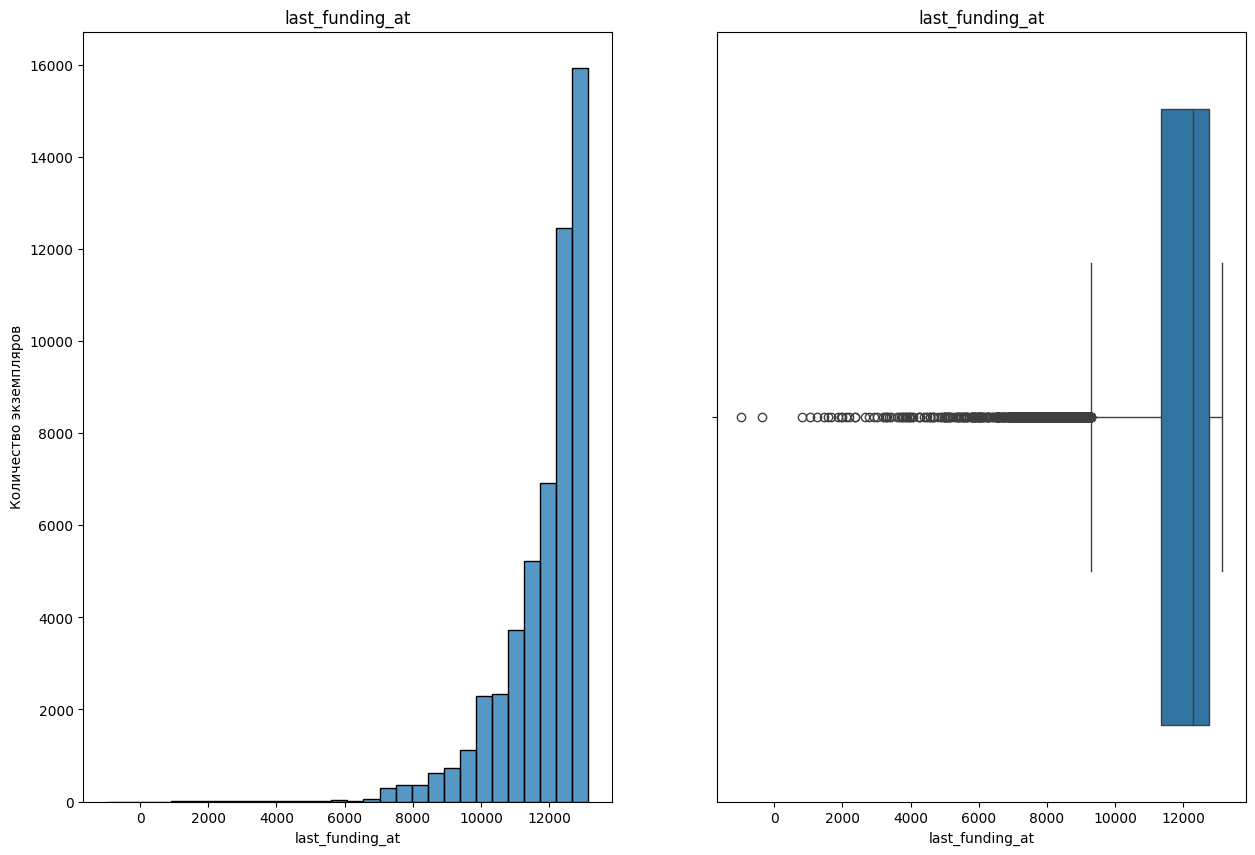

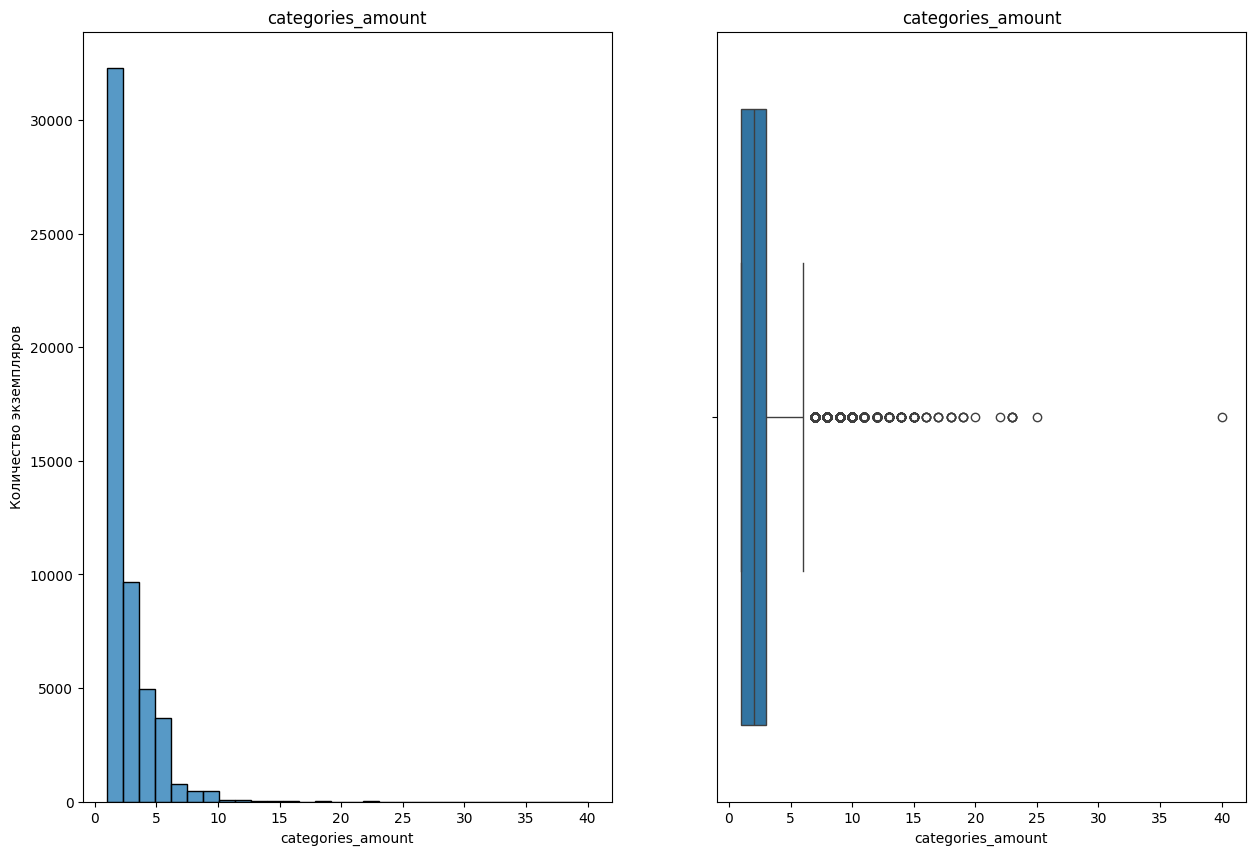

In [26]:
for column in numeric_columns:
	plotGraphsForNumericColumn(column)

In [27]:
def get_info(data_frame):
	print(data_frame.index)
	for column in data_frame.columns:
		print(column)
		print(len(data_frame[column].unique()))
		print(data_frame[column].unique())

In [28]:
get_info(kaggle_startups_train)

RangeIndex(start=0, stop=52516, step=1)
category_list
22106
['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']
funding_total_usd
15552
[  828626. 42935019. 35456381. ...  4582414.  3209000.   270820.]
status
2
['operating' 'closed']
country_code
135
['CHE' 'USA' 'no_country' 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS'
 'TWN' 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD'
 'ARG' 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA'
 'GRC' 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA'
 'JOR' 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX'
 'SVN' 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA'
 'TTO' 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT'
 'PSE' 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PR

In [29]:
get_info(kaggle_startups_test)

RangeIndex(start=0, stop=13125, step=1)
name
13125
['Crystalsol' 'JBI Fish & Wings' 'COINPLUS' ... 'Inkd.com' 'AdWill'
 'RingCentral']
category_list
6207
['Clean Technology' 'Hospitality' 'Finance' ...
 'Design|E-Commerce|Marketplaces|Printing'
 'Advertising Exchanges|Mobile|Mobile Advertising'
 'Communications Hardware|Messaging|Mobile|Office Space|Technology|VoIP']
funding_total_usd
4550
[ 2819200.        0.   428257. ...  8199999.  1353678. 50250000.]
country_code
97
['NIC' 'USA' 'LUX' 'CAN' 'no_country' 'MYS' 'DEU' 'GBR' 'FRA' 'ITA' 'CHN'
 'ARG' 'NLD' 'IRL' 'AUS' 'CHE' 'CHL' 'ESP' 'IND' 'ISR' 'DNK' 'KOR' 'RUS'
 'PHL' 'URY' 'SGP' 'BRA' 'EGY' 'MEX' 'POL' 'VNM' 'AUT' 'EST' 'BEL' 'DMA'
 'PRT' 'SWE' 'JOR' 'HUN' 'HKG' 'JPN' 'ZAF' 'COL' 'BGR' 'CZE' 'GRC' 'LTU'
 'TWN' 'ISL' 'IDN' 'FIN' 'NOR' 'ARE' 'UKR' 'KEN' 'NGA' 'TUR' 'CRI' 'THA'
 'CYP' 'ROM' 'MMR' 'VEN' 'BHR' 'NZL' 'SVK' 'CYM' 'LVA' 'MKD' 'PER' 'AZE'
 'BWA' 'BGD' 'ZWE' 'CIV' 'LKA' 'SVN' 'SRB' 'BLR' 'TAN' 'SAU' 'GHA' 'CMR'
 'TTO' 'PAK' 

<p>
Мы смотрим на данные, проверяем пропуски, заполняем недостающие данные заглушками. Пропуски в графе даты закрытия мы ставим 1 января 2018 года, так как датасет покрывает период до 2018 года. Это необходимо чтобы в рамкаих этого периода времени корректно рассчитывался столбец lifetime. Пропуски в общей сумме найденых средств мы заполняем нулями, так как подразумеваем, что если они не указаны, то их не было. 
</p>

<p>
Приводим данные дат к формату количества дней с 1 января 1980 года и удаляем лишние столбцы из тренировочной таблицы для того чтобы тестовые и тренировачные данные были в едином формате. 
</p>

<p>
Строим графики для количественных признаков (категорийные слишком разнообразны) чтобы визуально оценить распространение количественных значений. Смотрим на диапазон значений у данных.
</p>


## Создание столбцов категорий


In [30]:
category_set = {'PaaS'}

for category_list in kaggle_startups_train['category_list'].unique():
	if type(category_list) is str:
		for category in category_list.split('|'):
			category_set.add(category)

In [31]:
categories_train_dataframe = pd.DataFrame(columns=list(category_set), index=range(0, 52516)).fillna(0)
display(categories_train_dataframe)

/var/folders/2l/j55kj6cd07q3_76qd6w9vf5h_f4mp_/T/ipykernel_85804/1192470777.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  categories_train_dataframe = pd.DataFrame(columns=list(category_set), index=range(0, 52516)).fillna(0)


,Developer Tools,Contests,SEO,Media,Tea,RFID,Mechanical Solutions,Sports,Neuroscience,Enterprise 2.0,...,Charity,Local Services,Identity Management,Charities,Mobile Emergency&Health,Cloud-Based Music,Specialty Retail,FinTech,Cyber,Linux
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
for index, category_list in enumerate(kaggle_startups_train['category_list']):
	if type(category_list) is str:
		for category in category_list.split('|'):
			categories_train_dataframe.loc[index, category] = 1

In [33]:
train_dataframe = categories_train_dataframe.join(kaggle_startups_train)

In [34]:
display(train_dataframe.head(20))
print(train_dataframe.columns)
print(kaggle_startups_train.columns)

,Developer Tools,Contests,SEO,Media,Tea,RFID,Mechanical Solutions,Sports,Neuroscience,Enterprise 2.0,...,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,categories_amount
0,0,0,0,0,0,0,0,0,0,0,...,operating,CHE,25,Zurich,Zürich,2,11443,12753,2998,2
1,0,0,0,0,0,0,0,0,0,0,...,operating,USA,CA,SF Bay Area,Redwood City,4,11081,12474,4748,3
2,0,0,0,0,0,0,0,0,0,0,...,operating,USA,CA,SF Bay Area,San Jose,3,11920,12601,4383,1
3,0,0,0,0,0,0,0,0,0,0,...,operating,no_country,no_state,no_region,no_city,3,11566,12617,5114,1
4,0,0,0,0,0,0,0,0,0,0,...,operating,USA,VA,VA - Other,Bristol,1,11719,11719,2791,1
5,0,0,0,0,0,0,0,0,0,0,...,operating,USA,NJ,Newark,Princeton,1,12004,12004,2452,1
6,0,0,0,0,0,0,0,0,0,0,...,operating,USA,CA,SF Bay Area,Redwood City,1,12552,12552,6575,5
7,0,0,0,0,0,0,0,0,0,0,...,operating,USA,TX,Houston,Houston,1,12731,12731,4748,1
8,0,0,0,0,0,0,0,0,0,0,...,operating,USA,CA,SF Bay Area,Fremont,2,10143,11432,5479,1
9,0,0,0,0,0,0,0,0,0,0,...,operating,USA,TX,Austin,College Station,2,11557,12133,2922,1


Index(['Developer Tools', 'Contests', 'SEO', 'Media', 'Tea', 'RFID',
       'Mechanical Solutions', 'Sports', 'Neuroscience', 'Enterprise 2.0',
       ...
       'status', 'country_code', 'state_code', 'region', 'city',
       'funding_rounds', 'first_funding_at', 'last_funding_at', 'lifetime',
       'categories_amount'],
      dtype='object', length=867)
Index(['category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime', 'categories_amount'],
      dtype='object')


<p>
Мы создаём по 1 столбцу на каждую категорию из списка категорий с соответствующем столбце изначальной таблицы. Затем мы заполняем её данными пользовователей и соединяем с изначальной таблицей. 
</p>

## Корреляционный анализ

In [35]:
is_corr_analyze = True

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'first_funding_at', 'last_funding_at', 'lifetime', 'categories_amount']


/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable category_list is large: 22106. Are you sure this is not an interval variable? Analysis for pairs of variables including category_list can be slow.
  warnings.warn(
/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 4478. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(
/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1037. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(
/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2984310.

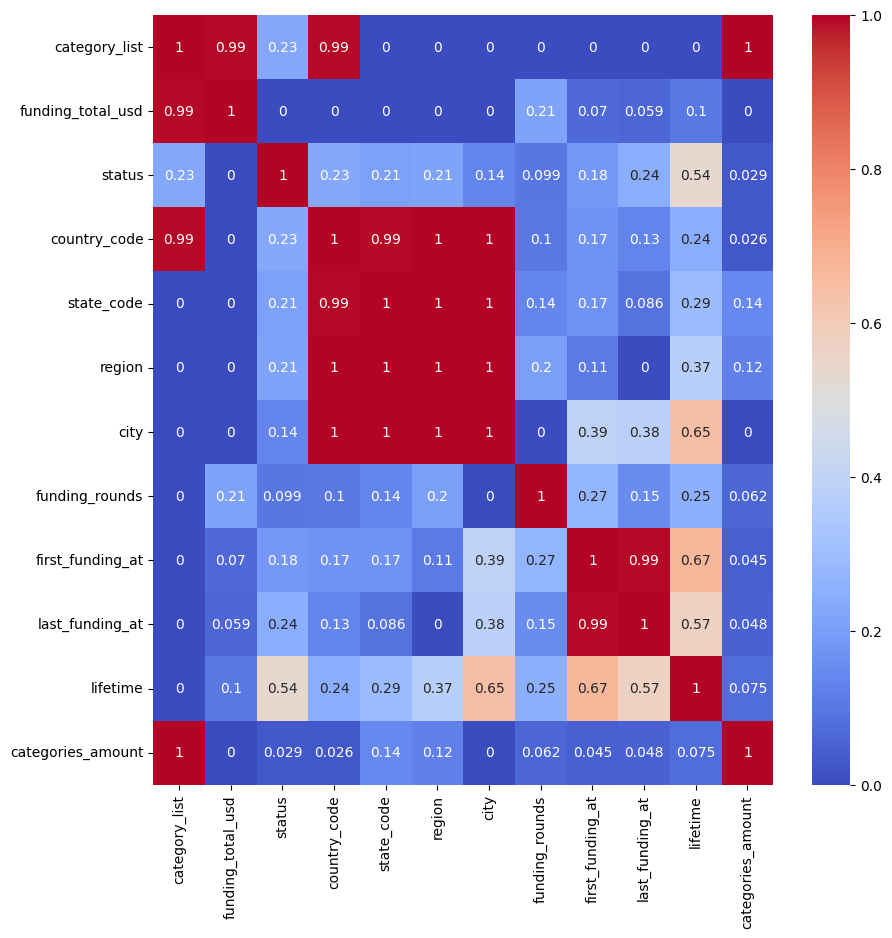

In [36]:
if (is_corr_analyze):
	correlation_matrix = phik_matrix(kaggle_startups_train)
	fig, ax = plt.subplots(figsize=(10,10)) 
	sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm', ax = ax)

In [37]:
columns_to_drop = ['category_list', 'region', 'state_code', 'country_code', 'last_funding_at']
train_dataframe = train_dataframe.drop(columns=columns_to_drop)

<p>
Мы проверяем корреляцию (исключая вновь созданные колонки категорий, иначе анализ становится неподъёмным). И удаляем лишние колонки чтобы избежать мультиколлинеарности.
</p>

## Создание пайплайна модели

In [38]:
target_column = 'status'

In [39]:
train_numeric_columns = ['funding_total_usd', 'funding_rounds', 'first_funding_at', 'lifetime', 'categories_amount']
train_categorical_columns = list(categories_train_dataframe.columns) + ['city']

In [40]:
RANDOM_STATE = 73

In [41]:
cat_pipe = Pipeline(
	[
		('simpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
		('cat', OneHotEncoder(drop='first', handle_unknown='ignore'))
	]
	)

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, train_categorical_columns),
        ('num', MinMaxScaler(), train_numeric_columns)
    ], 
    remainder='passthrough'
)

In [43]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

In [44]:
param_grid = [
	# словарь для градиентного бустинга GradientBoostingClassifier() 
	{
		'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
		'models__learning_rate': [0.3],
		'models__n_estimators': [185, 190, 195],
		'models__max_depth': [8],
		'models__min_samples_split': [2],
		'models__min_samples_leaf': [145, 150, 155],
		'models__criterion': ['friedman_mse', 'squared_error'],
		'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
	},
]

In [45]:
X = train_dataframe.drop([target_column], axis=1)
y = train_dataframe[target_column]
display(X)

,Developer Tools,Contests,SEO,Media,Tea,RFID,Mechanical Solutions,Sports,Neuroscience,Enterprise 2.0,...,Specialty Retail,FinTech,Cyber,Linux,funding_total_usd,city,funding_rounds,first_funding_at,lifetime,categories_amount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,828626.0,Zürich,2,11443,2998,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,42935019.0,Redwood City,4,11081,4748,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,35456381.0,San Jose,3,11920,4383,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,22250000.0,no_city,3,11566,5114,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,Bristol,1,11719,2791,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,Kitchener,1,12478,2192,1
52512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,500000.0,Hyderabad,1,12484,1590,1
52513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,50000.0,San Francisco,3,10757,2741,3
52514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13000000.0,San Jose,6,6908,7336,1


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2, 
    random_state = RANDOM_STATE,
    stratify = y)

In [47]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [48]:
grid_search.fit(X_train, y_train)

/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [172, 291, 436, 709, 762, 836, 855] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [155, 342, 421, 426, 518, 828, 855] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [155, 342, 421, 426, 518, 828, 855] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleImputer_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Developer '
                                                                          'Tools',
                                                                          'Contests',
                                                                          'SEO',
                                                                          'Media',
                                                                          'Tea',
                                                                          'RFID',
                                                                          'Mechanical '
                                                                          'Solutions',
                                                                          'Spor...
             param_grid=[{'models': [GradientBoostingClassifier(random_state=73)],
                          'models__criterion': ['friedman_mse',
                                                'squared_error'],
                          'models__learning_rate': [0.3],
                          'models__max_depth': [8],
                          'models__min_samples_leaf': [145, 150, 155],
                          'models__min_samples_split': [2],
                          'models__n_estimators': [185, 190, 195],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [49]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели во время кросс валидации:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Developer Tools',
                                                   'Contests', 'SEO', 'Media',
                                                   'Tea', 'RFID',
                                                   'Mechanical Solutions',
                                                   '

<p>
Мы создаём пайплайн для обработки данных. Выбираем несколько моделей и затем перебираем их гиперпараметры в сетке, оптимизируя метрик roc-auc.
</p>

<p>
Получаем, что лучшая модель это - градиентный бустинг над решающими деревьями со следующими гиперпараметрами learning_rate=0.3, max_depth=8, min_samples_leaf=145, n_estimators=185
</p>


<p>
Были также рассмотрены другие, более простые модели - логистиечская регрессия, модель knn, метод опорных векторов, но все они далее худший результат чем градиентный бустинг, а при включении их в финальные параметры сетки вычисления занимают очень много времени. 
</p>

## Вычисление и сохранение предсказания

In [50]:
kaggle_startups_test.info()
kaggle_startups_test['categories_amount'] = kaggle_startups_test['category_list'].apply(lambda x: len(x.split('|')))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  int64  
 9   last_funding_at    13125 non-null  int64  
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.1+ MB


In [51]:
categories_test_dataframe = pd.DataFrame(columns=list(category_set), index=range(0, 13125)).fillna(0)
display(categories_test_dataframe)

/var/folders/2l/j55kj6cd07q3_76qd6w9vf5h_f4mp_/T/ipykernel_85804/1644045891.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  categories_test_dataframe = pd.DataFrame(columns=list(category_set), index=range(0, 13125)).fillna(0)


,Developer Tools,Contests,SEO,Media,Tea,RFID,Mechanical Solutions,Sports,Neuroscience,Enterprise 2.0,...,Charity,Local Services,Identity Management,Charities,Mobile Emergency&Health,Cloud-Based Music,Specialty Retail,FinTech,Cyber,Linux
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
kaggle_startups_test.info()
categories_test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  int64  
 9   last_funding_at    13125 non-null  int64  
 10  lifetime           13125 non-null  int64  
 11  categories_amount  13125 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Columns: 855 entries, Developer Tools to Linux
dtypes: int64(855)
memory usage: 8

In [53]:
test_dataframe = categories_test_dataframe.join(kaggle_startups_test)
test_dataframe = test_dataframe.drop(columns=columns_to_drop)

In [54]:
predictions = grid_search.predict(test_dataframe)

/Users/vaskutuzow/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [855] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [55]:
display(predictions)

array(['operating', 'operating', 'operating', ..., 'operating',
       'operating', 'operating'], dtype=object)

In [56]:
predictions_for_caggle = pd.Series(predictions, index=test_dataframe['name'])

In [57]:
display(predictions_for_caggle)

name
Crystalsol                operating
JBI Fish & Wings          operating
COINPLUS                  operating
Imagine Communications    operating
DNA13                     operating
                            ...    
Jymob                     operating
GlobaTrek                 operating
Inkd.com                  operating
AdWill                    operating
RingCentral               operating
Length: 13125, dtype: object

In [58]:
data_frame_for_caggle = pd.DataFrame(columns=['status'], data=predictions_for_caggle.values)
data_frame_for_caggle = data_frame_for_caggle.set_index(predictions_for_caggle.index)
display(data_frame_for_caggle)

,status
name,
Crystalsol,operating
JBI Fish & Wings,operating
COINPLUS,operating
Imagine Communications,operating
DNA13,operating
...,...
Jymob,operating
GlobaTrek,operating
Inkd.com,operating


In [59]:
data_frame_for_caggle.to_csv('../../data/predictions_workshop1.csv')

<p>
Мы вычислили предсказание на тестовых данных и отправили их на платформу kaggle для проверки точности, итоговый результат равен - 0.882.
</p>

## Вывод

<p>
На первом этапе мы провели начальный осмотр данных, заполнили пропуски в данных и привели данные к единому формату в обоих датасетах - тестовом и тренировочном.
</p>

<p>
Затем в процессе подготовки тренировочного датасета к использованию в обучении модели мы создали множество новых категорийных столбцов из столбца со списком категорий, затем провели анализ корреляций и удалили столбцы из коррелирующих пар. Следюущим шагом мы построили пайплайн и с его помощью перебрали в сетке несколько моделей и выбрали лучшую модель и её гиперпараметры.  
</p>

<p>
Эта модель - градиентный бустинг над решающими деревьями (гиперпараметры можно увидеть в соответствующем пункте), на тестовых данных при кросс валидации она дала значени roc-auc в 0.97598. При вычислении метрики на тестовых данных при помощи платформы caggle лучшее значение около 0.882.
</p>

<p>
Следует отдельно отметить - формально поставленная задача решена с той или иной степенью удовлетворительности, в зависимости от требований условного "заказчика". Но есть принципиальная проблема в самой постановке задачи. Дело в том, что мы имеем всю информацию о стартапе до 2018 года, то есть лучшее, что мы можем предсказать теоретически это то обанкротился ли стартап к данному моменту или нет. Это не выглядит как полезная информация учитывая, что находясь в данном моменте мы и так знаем обанкротился ли стартап. Если бы мы хотели получить модель, которая претендовала бы на бОльшую предсказательную силу, то нам стоило оставить данные до какого-то года (до 2018, например 2015) и оставить столбец с целевым признаком отмечающим обанкротился ли стартап в 2018 году, тогда на выходе мы могли бы сказать, что модель с некоторой точностью предсказывает банкротство в следующие три года. В текущей же постановке задачи и наборе данных при наличии условно идеальной модели мы лишь предскажем уже существующее пололжение дел, что полезно как обучающая задача, но затруднительно с точки зрения использования для предсказаний.
</p>

<p>
Можно однако сказать, что теоретически мы можем попытаться получить предсказания как некую интерпретацию нашей модели - довести её до высокой точности и интерпретировать те стартапы, которые она пометила как закрывшиеся, но которые фактически функционируют (false positive error) как то, что эти стартапы схожи с уже закрывшимися, а значит имеют вероятность обанкротиться в ближайшее время. Точность такого метода нуждается в дополнительном исследовании. 
</p>